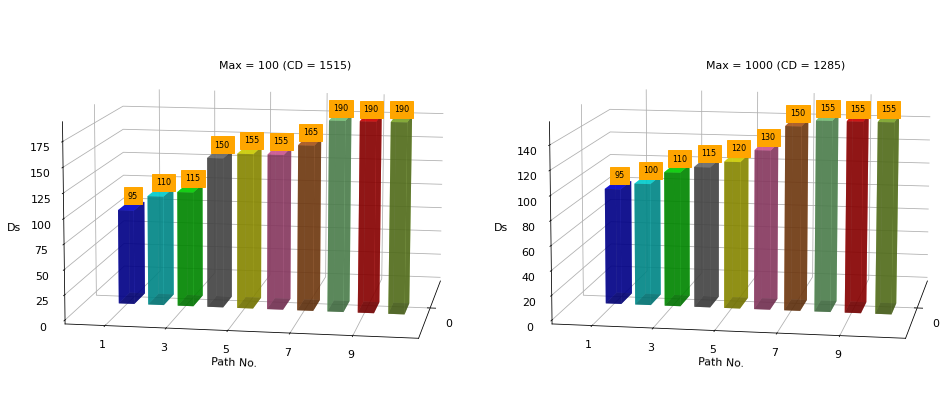

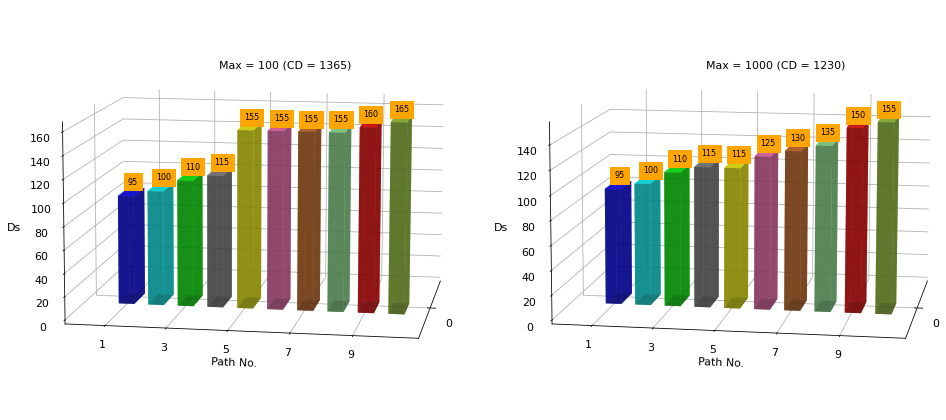

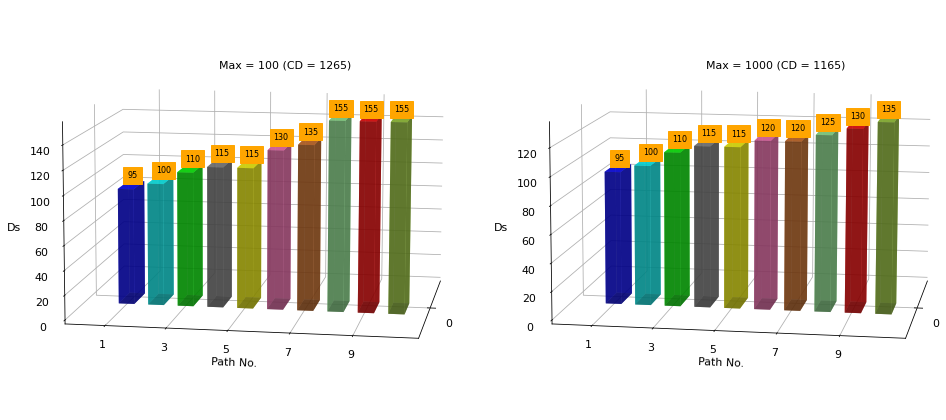

In [14]:
import numpy as np
import random
import math
import copy
from Draw_2_charts import BarChart

class Solution(object):
    def __init__(self):
        self.path = []
        self.code = []
        self.fitness = float('inf')
        self.fitness_vector = 0
        self.counter = 0
        self.prob = 0

class ABC:

    def __init__(self, src, dst, N, Max, K_paths, st):
        self.switches = [i for i in range(1,31)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.population = [self.CreateSolution() for i in range(self.N)]
        self.limit = int(math.sqrt(N+len(self.switches)))
        self.condidates = []
        self.best = []
        self.st = st
        self.values = []
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('../../metric_data.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreateSolution(self):
        newSolution = Solution()
        path=[]
        code = []
        while(len(path)==0):
            code.clear()
            path.clear()
            code = copy.deepcopy([random.uniform(-1,1) for i in range(len(self.switches))])
            path = copy.deepcopy(self.Decode(code))
        newSolution.code = copy.deepcopy(code)
        newSolution.path = copy.deepcopy(path)
        newSolution.fitness = self.Evaluate(newSolution.path)
        return newSolution
    
    def Decode(self,code):
        path = []
        path.append(self.src)
        current_switch = self.src
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                path.clear()
                break
            switch_min = 1
            min = float('inf')
            for switch in neighbor_switches:
                if(code[switch-1] <= min):
                    min = code[switch-1]
                    switch_min = switch
            current_switch = switch_min
            path.append(current_switch)
        return path

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def Normalize(self,code):
        code_2 = copy.deepcopy(code)
        mn = min(code_2)
        mx = max(code_2)
        for j in range(len(self.switches)):
            code[j] = -1+2*(code_2[j]-mn)/(mx-mn)
        return code

    def InitializationPhase(self):
        for i in range(self.N):
            mn = min(self.population[i].code)
            mx = max(self.population[i].code)
            self.population[i].code.clear()
            path=[]
            code = []
            while(len(path)==0):
                code.clear()
                path.clear()
                code = copy.deepcopy([(mn+np.random.rand()*(mx-mn)) for i in range(len(self.switches))])
                path = copy.deepcopy(self.Decode(code))
            self.population[i].code = copy.deepcopy(code)
            self.population[i].path = copy.deepcopy(path)
            self.population[i].fitness = self.Evaluate(self.population[i].path)
    
    def EmployeedPhase(self):
        population = copy.deepcopy(self.population)
        for i in range(self.N):
            r = list(range(0,i)) + list(range(i+1,self.N))
            coceg = random.choice(r)
            solution = copy.deepcopy(self.population[i])
            code = copy.deepcopy(self.population[i].code)
            path = []
            d = np.random.randint(len(self.switches)-1)
            while(len(path)==0):
                fi = random.uniform(-1,1)
                for ii in range(len(self.switches)):
                    if(ii==d):
                        code[ii] = solution.code[ii]+fi*(solution.code[ii]-self.population[coceg].code[ii])
                    else:
                        code[ii] = solution.code[ii]
                code = self.Normalize(code)
                path = copy.deepcopy(self.Decode(code))
            solution.code = copy.deepcopy(code)
            solution.path = copy.deepcopy(path)
            solution.fitness = self.Evaluate(solution.path)
            if(solution.fitness<population[i].fitness):
                solution.counter = 0
                population[i] = copy.deepcopy(solution)
            else:
                population[i].counter+=1
        self.population=copy.deepcopy(population)

    def OnlookedPhase(self):
        for i in range(self.N):
            self.population[i].fitness_vector = 1/self.population[i].fitness
        sum = 0
        for i in range(self.N):
            sum+=self.population[i].fitness_vector
        prob=[]
        for i in range(self.N):
            self.population[i].prob=self.population[i].fitness_vector/sum
        for i in range(self.N):
            prob.append(self.population[i].prob)
        population= copy.deepcopy(self.population)
        for i in range(self.N):
            index_solution = np.random.choice(list(range(self.N)),p=prob)
            r = list(range(0,index_solution)) + list(range(index_solution+1,self.N))
            coceg = random.choice(r)
            solution = copy.deepcopy(self.population[index_solution])
            code =copy.deepcopy(solution.code)
            path = []
            d = np.random.randint(len(self.switches)-1)
            while(len(path)==0):
                fi = random.uniform(-1,1)
                for ii in range(len(self.switches)):
                    if(ii==d):
                        code[ii] = solution.code[ii]+fi*(solution.code[ii]-self.population[coceg].code[ii])
                    else:
                        code[ii] = solution.code[ii]
                code = self.Normalize(code)
                path = copy.deepcopy(self.Decode(code))
            solution.code = copy.deepcopy(code)
            solution.path = copy.deepcopy(path)
            solution.fitness = self.Evaluate(solution.path)
            if(solution.fitness<population[index_solution].fitness):
                solution.counter = 0
                population[index_solution] = copy.deepcopy(solution)
            else:
                population[index_solution].counter+=1
        self.population=copy.deepcopy(population)

    def ScoutPhase(self):
        for i in range(self.N):
            if self.population[i].counter > self.limit:
                self.population[i] = copy.deepcopy(self.CreateSolution())
    
    def MemorizeCondidates(self):
        self.population.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.population)):
            dk_3 = False
            for member in condidate:
                if(tuple(member.path)==tuple(self.population[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.population[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))
    
    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for solution in self.best:
                if(tuple(solution.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
        for x in range(len(self.best)):
            self.values.append(self.best[x].fitness)
        file1 = open('../../wires.txt','r')
        Lines = file1.readlines()
        count = 0
        for line in Lines:
            if(line.strip()[0] == "a"):
                count += 1
        file1.close()
        f1 = open("../../wires.txt","a")
        if(count==6):
            f1.truncate(0)
        stt_0 = ",".join([self.st,str(self.N),str(self.Max)]) + "\n"
        f1.write(stt_0)
        for i in range(len(self.best)):
            stt = ",".join(str(self.weight_map[self.best[i].path[x]][self.best[i].path[x+1]]) for x in range(len(self.best[i].path) - 1))
            stt= stt+"\n"
            f1.write(stt)
        f1.close()

    def Do(self):
        self.InitializationPhase()
        for i in range(self.Max):
            self.EmployeedPhase()
            self.OnlookedPhase()
            self.ScoutPhase()
            self.MemorizeCondidates()
        self.GetBest()
N = [10,25,50]
Max = 1000
K_paths = 10
src = 1
dst = 30
st = "al_ABC"
alg_00 = ABC(src,dst,N[0],Max[0],K_paths,st)
alg_00.Do()
alg_01 = ABC(src,dst,N[0],Max[1],K_paths,st)
alg_01.Do()
chart = BarChart(alg_00.values, alg_01.values, "10")
chart.Do()
alg_10 = ABC(src,dst,N[1],Max[0],K_paths,st)
alg_10.Do()
alg_11 = ABC(src,dst,N[1],Max[1],K_paths,st)
alg_11.Do()
chart = BarChart(alg_10.values, alg_11.values, "25")
chart.Do()
alg_20 = ABC(src,dst,N[2],Max[0],K_paths,st)
alg_20.Do()
alg_21 = ABC(src,dst,N[2],Max[1],K_paths,st)
alg_21.Do()
chart = BarChart(alg_20.values, alg_21.values, "50")
chart.Do()
f=open("../../demo.txt","w")
f.truncate(0)
for i in range(len(alg_21.best)):
    stt = ",".join(str(x) for x in alg_21.best[i].path)
    stt= stt+","+str(alg_21.best[i].fitness)+"\n"
    f.write(stt)
f.close()